In [1]:
import numpy as np
import pandas as pd

from collections import Counter

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data
iris = load_iris()
feature_names = [feature_name[:-5] for feature_name in iris.feature_names]

df = pd.DataFrame(iris.data, columns=feature_names)
df['label']  = iris.target

In [3]:
df

,sepal length,sepal width,petal length,petal width,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


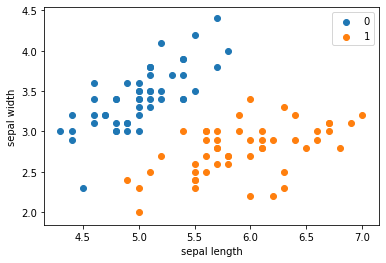

In [4]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [5]:
data = np.array(df.iloc[:100, [0, 1, -1]])
X, y = data[:, :-1], data[:, -1]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
class KNN:
    def __init__(self, k=3, p=2):
        self.k = k
        self.p = p
    
    def fit(self, points, labels):
        if not isinstance(points, np.ndarray): points = np.array(points)
        if not isinstance(labels, np.ndarray): points = np.array(labels)
        self.points = points
        self.labels = labels
        
    def predict(self, x):
        dist = ((self.points - x)**2).sum(axis=1) ** (1./self.p)
        nn_idxs = np.argsort(dist)[:self.k]
        nn_labels = self.labels[nn_idxs]
        
        label_count = Counter(nn_labels)
        return int(sorted(label_count)[-1])
    
    def evaluate(self, x_test, y_test):
        correct = 0
        for x, y in zip(x_test, y_test):
            label = self.predict(x)
            if label == y:
                correct += 1
        return correct / len(x_test)

In [7]:
clf = KNN()
clf.fit(x_train, y_train)

In [8]:
clf.evaluate(x_test, y_test)

1.0

In [9]:
test_point = [5., 2.8]
clf.predict(test_point)

1

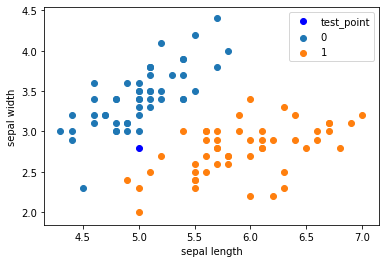

In [10]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.plot(test_point[0], test_point[1], 'bo', label='test_point')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

## **kd-tree**

In [11]:
class Node:
    def __init__(self):
        self.point = None
        self.split = None
        self.parent = None
        self.left = None
        self.right = None

In [12]:
class KdTree:
    def __init__(self):
        self.root = Node()
        self.nearest = None
        self.min_dist = float('inf')
    
    def _get_variance(self, X, d):  # DX = E(X²) - (EX)²
        if not isinstance(X, np.ndarray): X = np.array(X)
        n = len(X)
        EX_sqr = (X.sum(axis=0)[d] / n) ** 2
        E_sqrX = (X**2).sum(axis=0)[d] / n
        
        return E_sqrX - EX_sqr
    
    def _get_split(self, X):  # 在剩下的数据集X里面找方差最大的维度作为分割轴
        k = len(X[0])
        variances =  map(lambda d: (d, self._get_variance(X, d)), range(k))
        return max(variances, key=lambda x: x[1])[0]
        
    def _get_median(self, X, split):
        n = len(X)
        k = n // 2
        sorted_idxs = np.argsort(X, axis=0)[:, split]
        left_idxs, median_idx, right_idxs = sorted_idxs[:k], sorted_idxs[k], sorted_idxs[k+1:]
        return median_idx, (left_idxs, right_idxs)
        
    def build_tree(self, X, y=None):
        nd = self.root
        self._build_tree(nd, X)
    
    def _build_tree(self, nd, X, y=None):
        if X is None or len(X) == 0: return
        
        split = self._get_split(X)
        median_idx, (left_idxs, right_idxs) = self._get_median(X, split)
        nd.point = X[median_idx]
        nd.split = split
        
        if len(left_idxs) > 0:
            nd.left = Node()
            nd.left.parent = nd
            self._build_tree(nd.left, X[left_idxs])
        
        if len(right_idxs) > 0:
            nd.right = Node()
            nd.right.parent = nd
            self._build_tree(nd.right, X[right_idxs])
    
    def preorder(self, nd=None):
        if nd is None: nd = self.root
        print(nd.point)
        if nd.left:
            self.preorder(nd.left)
        if nd.right:
            print('RRRR')
            self.preorder(nd.right)
    
    def _dist(self, x1, x2, p=2):
        return ((x1 - x2) ** p).sum() ** (1./p)
    
    def _get_brother(self, nd):
        if nd.parent is None: 
            return None
        if nd is nd.parent.left:
            return nd.parent.right
        else:
            return nd.parent.left
    
    def search(self, x, nd=None):
        if nd is None:
            nd = self.root
        while nd.left or nd.right:
            if not nd.left:
                nd = nd.right
            elif not nd.right:
                nd = nd.left
            elif nd.point[nd.split] > x[nd.split]:
                nd = nd.left
            else:
                nd = nd.right
        return nd
    
    def _intersect(self, nd, x):
        if nd.parent is None: return False
        nd = nd.parent
        return abs(nd.point[nd.split] - x[nd.split]) <= self.min_dist
        
    def find_nearest(self, x):
        self.nearest = self.search(x)
        self.min_dist = self._dist(self.nearest.point, x)
        self._find_nearest(self.nearest, x)
        return self.nearest.point, self.min_dist
    
    def _find_nearest(self, nd, x):
        dis = self._dist(nd.point, x)
        print(nd.point, dis, self.min_dist)  # search path
        if dis < self.min_dist:
            self.min_dist = dis
            self.nearest = nd
            
        if self._intersect(nd, x):
            brother = self._get_brother(nd)
            _nd = self.search(x, brother)
            _dis = self._dist(_nd.point, x)
            print(_nd.point, _dis, self.min_dist)  # search path
            if _dis < self.min_dist:
                self.min_dist = _dis
                self.nearest = _nd   
        
        if nd.parent:
            self._find_nearest(nd.parent, x)

In [13]:
data = [(0, 25, 73), (1, 91, 85), (1, 47, 12), (2, 90, 20),
      (2, 66, 79), (2, 46, 27), (4, 48, 99), (5, 73, 64), (7, 42, 70),
      (7, 34, 60), (8, 86, 80), (10, 27, 14), (15, 64, 39), (17, 74, 24),
      (18, 58, 12), (18, 58, 5), (19, 14, 2), (20, 88, 11), (20, 28, 58),
      (20, 79, 48), (21, 32, 8), (21, 46, 41), (22, 6, 4), (22, 42, 68),
      (22, 62, 42), (24, 70, 96), (27, 77, 57), (27, 47, 39), (28, 61, 19),
      (30, 28, 22), (34, 13, 85), (34, 39, 96), (34, 90, 32), (39, 7, 45),
      (40, 61, 53), (40, 69, 50), (41, 45, 16), (41, 15, 44), (42, 40, 19),
      (45, 6, 68), (46, 79, 91), (47, 91, 86), (47, 50, 24), (48, 57, 64),
      (49, 21, 72), (49, 87, 21), (49, 41, 62), (54, 94, 32), (56, 14, 54),
      (56, 93, 2), (58, 34, 44), (58, 27, 42), (59, 62, 80), (60, 69, 69),
      (61, 67, 35), (62, 31, 50), (63, 9, 93), (63, 46, 95), (64, 31, 2),
      (64, 2, 36), (65, 23, 96), (66, 94, 69), (67, 98, 10), (67, 40, 88),
      (68, 4, 15), (68, 1, 6), (68, 88, 72), (70, 24, 53), (70, 31, 87),
      (71, 95, 26), (74, 80, 34), (75, 59, 99), (75, 15, 25), (76, 90, 99),
      (77, 75, 19), (77, 68, 26), (80, 19, 98), (82, 90, 50), (82, 87, 37),
      (84, 88, 59), (85, 76, 61), (85, 89, 20), (85, 64, 64), (86, 55, 92),
      (86, 15, 69), (87, 48, 46), (87, 67, 47), (89, 81, 65), (89, 87, 39),
      (89, 87, 3), (91, 65, 87), (94, 37, 74), (94, 20, 92), (95, 95, 49),
      (96, 15, 80), (96, 27, 39), (97, 87, 32), (97, 43, 7), (98, 78, 10),
      (99, 64, 55)]
kd = KdTree()
kd.build_tree(np.array(data))
# kd.layerorder()

In [14]:
nn, nn_dist = kd.find_nearest(np.array((66, 54, 29)))
print(nn, nn_dist)

[64 31  2] 35.52463933666322 35.52463933666322
[64 31  2] 35.52463933666322 35.52463933666322
[97 43  7] 39.57271787481876 35.52463933666322
[75 15 25] 40.22437072223753 35.52463933666322
[58 27 42] 31.016124838541646 35.52463933666322
[96 27 39] 41.58124577258358 31.016124838541646
[94 37 74] 55.65968020030299 31.016124838541646
[61 67 35] 15.165750888103101 31.016124838541646
[85 64 64] 41.060930335295616 15.165750888103101
[28 61 19] 39.91240408695021 15.165750888103101
[58 34 44] 26.248809496813376 15.165750888103101
[61 67 35] 15.165750888103101


In [15]:
kd._dist(np.array([66,54,29]), np.array([61,67,35]))

15.165750888103101

In [16]:
# enumerate over all points
min_dist = float('inf')
nn = None
for p in data:
    dist = kd._dist(np.array(p), np.array([66, 54, 29]))
    if dist < min_dist:
        min_dist = dist
        nn = p
print(nn, min_dist)

(61, 67, 35) 15.165750888103101
